In [ ]:
!pip install -q kaggle

In [ ]:
from getpass import getpass
import os
user = 'aya25hassan'
key = '90e6ead9472ce545a5494f7ec775ed57'

if '.kaggle' not in os.listdir('/root'):
    !mkdir -p ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!chmod 777 *
!kaggle competitions download -c state-farm-distracted-driver-detection

100% 3.98G/4.00G [00:28<00:00, 141MB/s]
100% 4.00G/4.00G [00:28<00:00, 149MB/s]


#### unzip dataset

In [ ]:
!unzip state-farm-distracted-driver-detection.zip

In [ ]:
# !pip install seaborn

#### Import libraries and prepare Dataset

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np 
import pandas as pd 
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization , Input
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models , layers , optimizers,regularizers
from keras.applications.vgg19 import VGG19

In [ ]:
path_train = "imgs/train"
classes = [c for c in os.listdir(path_train) if not c.startswith(".")]
classes.sort()
print(classes)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [ ]:
class_dict = {0 : "safe driving",
              1 : "texting - right",
              2 : "talking on the phone - right",
              3 : "texting - left",
              4 : "talking on the phone - left",
              5 : "operating the radio",
              6 : "drinking",
              7 : "reaching behind",
              8 : "hair and makeup",
              9 : "talking to passenger"}

Total number of training data : 22424


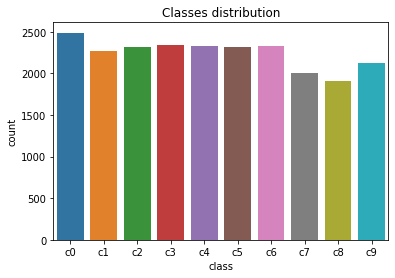

In [ ]:
d = {"img" : [], "class" : []}
for c in classes:
    imgs = [img for img in os.listdir(os.path.join(path_train,c)) if not img.startswith(".")]
    for img in imgs:
        d["img"].append(img)
        d["class"].append(c)
df = pd.DataFrame(d)
ax = sns.countplot(data=df,x="class")
ax.set(title="Classes distribution")
print("Total number of training data :",len(df))

In [ ]:
df = pd.read_csv('driver_imgs_list.csv')
df

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


In [ ]:
df['path'] = 'imgs/train/' + df['classname']+ '/' +df['img']
print(df['path'][0])

imgs/train/c0/img_44733.jpg


In [ ]:
images = df[['path',"classname"]]
labels=df['classname']

In [ ]:
df.head()

,subject,classname,img,path
0,p002,c0,img_44733.jpg,imgs/train/c0/img_44733.jpg
1,p002,c0,img_72999.jpg,imgs/train/c0/img_72999.jpg
2,p002,c0,img_25094.jpg,imgs/train/c0/img_25094.jpg
3,p002,c0,img_69092.jpg,imgs/train/c0/img_69092.jpg
4,p002,c0,img_92629.jpg,imgs/train/c0/img_92629.jpg


#### Split Dataset into Train and Validation

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(images,labels,test_size=0.2,shuffle=True)

In [ ]:
datagen = ImageDataGenerator(rescale=1./255) 

train_generator = datagen.flow_from_dataframe(
        x_train,  
        x_col='path',
        y_col='classname',
        batch_size=64,
        target_size=(256,256),
        class_mode="categorical",
        shuffle=True
)

Found 17939 validated image filenames belonging to 10 classes.


In [ ]:
for i in range(5):
    img, label = train_generator.next()
    print(img.shape)

(64, 256, 256, 3)
(64, 256, 256, 3)
(64, 256, 256, 3)
(64, 256, 256, 3)
(64, 256, 256, 3)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255) 

val_generator = datagen.flow_from_dataframe(
        x_val, 
        x_col='path',
        y_col='classname',
        batch_size=64,
        target_size=(256,256),
        class_mode="categorical",
        shuffle=True
)

Found 4485 validated image filenames belonging to 10 classes.


#### 1.Baseline Model 

In [ ]:
baseline = models.Sequential([
    (layers.Input(shape = (256*256*3,))),
    (layers.Flatten()),
    (layers.Dense(512, activation='relu', name='Layer_1')),
    (layers.Dense(256, activation='relu', name='Layer_2')),
    (layers.Dense(128, activation='relu', name='Layer_3')),
    (layers.Dense(10, activation='softmax')),
])

baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 Layer_1 (Dense)             (None, 512)               100663808 
                                                                 
 Layer_2 (Dense)             (None, 256)               131328    
                                                                 
 Layer_3 (Dense)             (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 100,829,322
Trainable params: 100,829,322
Non-trainable params: 0
_________________________________________________________________


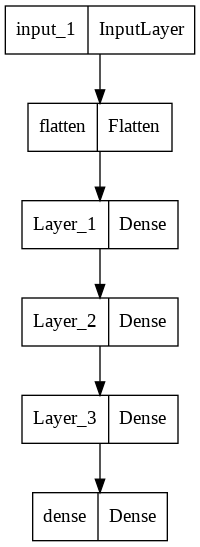

In [ ]:
plot_model(baseline)

In [ ]:
baseline.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
baseline_history = baseline.fit(train_generator,validation_data=val_generator, epochs=5,steps_per_epoch=STEP_SIZE_TRAIN, validation_steps= STEP_SIZE_VALID)

Epoch 1/5
280/280 [==============================] - 112s 400ms/step - loss: 0.2442 - accuracy: 0.9257 - val_loss: 0.1168 - val_accuracy: 0.9647
Epoch 2/5
280/280 [==============================] - 111s 395ms/step - loss: 0.0860 - accuracy: 0.9735 - val_loss: 0.0827 - val_accuracy: 0.9743
Epoch 3/5
280/280 [==============================] - 112s 402ms/step - loss: 0.0809 - accuracy: 0.9737 - val_loss: 0.1248 - val_accuracy: 0.9598
Epoch 4/5
280/280 [==============================] - 110s 392ms/step - loss: 0.1516 - accuracy: 0.9515 - val_loss: 0.1708 - val_accuracy: 0.9496
Epoch 5/5
280/280 [==============================] - 111s 395ms/step - loss: 0.1361 - accuracy: 0.9559 - val_loss: 0.1108 - val_accuracy: 0.9616


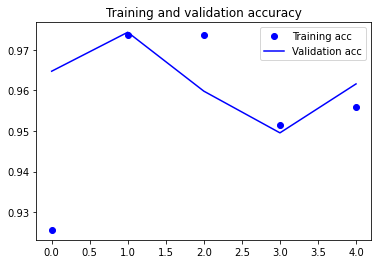

In [ ]:
acc = baseline_history.history['accuracy']
val_acc = baseline_history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()


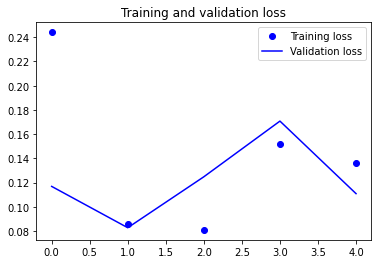

In [ ]:
loss = baseline_history.history['loss']
val_loss = baseline_history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### 2.Baseline CNN Model 

In [ ]:
baseline_CNN = models.Sequential()
baseline_CNN.add(layers.Conv2D(32, (3, 3), input_shape=(256,256,3), activation='relu', padding='same')) 
baseline_CNN.add(layers.MaxPooling2D(pool_size=(2, 2))) 
baseline_CNN.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same')) 
baseline_CNN.add(layers.MaxPooling2D(pool_size=(2, 2))) 
baseline_CNN.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))  
baseline_CNN.add(layers.Flatten()) 
baseline_CNN.add(layers.Dense(128, activation='relu', kernel_constraint=maxnorm(3))) 
baseline_CNN.add(layers.Dense(64, activation='relu', kernel_constraint=maxnorm(3))) 
baseline_CNN.add(layers.Dense(10,activation='softmax'))
baseline_CNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 flatten_4 (Flatten)         (None, 524288)           

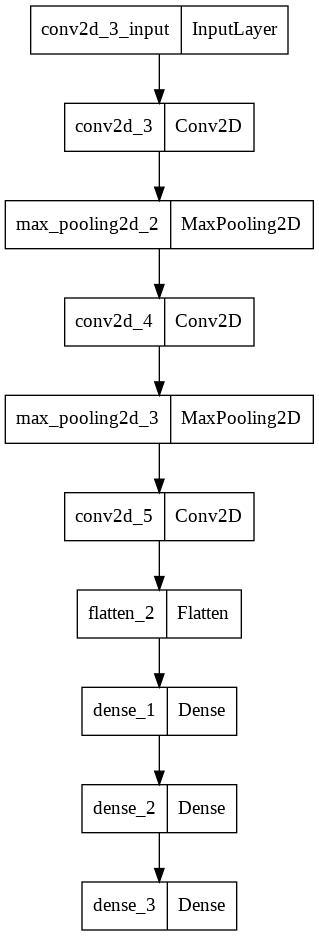

In [ ]:
plot_model(baseline_CNN)

In [ ]:
baseline_CNN.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
baseline_CNN_history = baseline_CNN.fit(train_generator,validation_data=val_generator, epochs=5,steps_per_epoch=STEP_SIZE_TRAIN, validation_steps= STEP_SIZE_VALID)

Epoch 1/5
280/280 [==============================] - 137s 448ms/step - loss: 0.8452 - accuracy: 0.7510 - val_loss: 0.0454 - val_accuracy: 0.9868
Epoch 2/5
280/280 [==============================] - 124s 444ms/step - loss: 0.0550 - accuracy: 0.9877 - val_loss: 0.0284 - val_accuracy: 0.9933
Epoch 3/5
280/280 [==============================] - 124s 442ms/step - loss: 0.0179 - accuracy: 0.9959 - val_loss: 0.0312 - val_accuracy: 0.9953
Epoch 4/5
280/280 [==============================] - 123s 437ms/step - loss: 0.0107 - accuracy: 0.9974 - val_loss: 0.0394 - val_accuracy: 0.9951
Epoch 5/5
280/280 [==============================] - 133s 474ms/step - loss: 0.0156 - accuracy: 0.9977 - val_loss: 0.0554 - val_accuracy: 0.9902


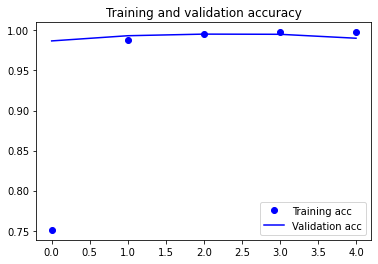

In [ ]:
acc = baseline_CNN_history.history['accuracy']
val_acc = baseline_CNN_history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()


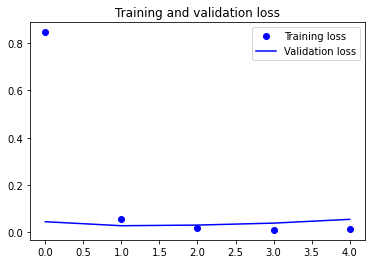

In [ ]:
loss = baseline_CNN_history.history['loss']
val_loss = baseline_CNN_history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### 3.Data Augmentation

In [ ]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [ ]:
train_generator = datagen_train.flow_from_dataframe(
        x_train,  
        x_col='path',
        y_col='classname',
        batch_size=32,
        target_size=(256,256),
        class_mode="categorical",
        shuffle=True
)

Found 17939 validated image filenames belonging to 10 classes.


In [ ]:
datagen_valid = ImageDataGenerator(rescale=1./255) 

val_generator = datagen_valid.flow_from_dataframe(
        x_val,  
        x_col='path',
        y_col='classname',
        batch_size=32,
        target_size=(256,256),
        class_mode="categorical",
        shuffle=True
)

Found 4485 validated image filenames belonging to 10 classes.


----
###### A


In [ ]:
Aug_CNN = models.Sequential()
Aug_CNN.add(layers.Conv2D(128, (3, 3), activation='relu', name = 'Layer1', input_shape=(256,256,3,)))
Aug_CNN.add(layers.MaxPooling2D())
Aug_CNN.add(layers.Conv2D(64, (3, 3), activation='relu', name = 'Layer2'))
Aug_CNN.add(layers.MaxPooling2D())
Aug_CNN.add(layers.Dropout(0.5))
Aug_CNN.add(layers.Conv2D(128, (3, 3), activation='relu', name = 'Layer3'))
Aug_CNN.add(layers.BatchNormalization(axis = 3))
Aug_CNN.add(layers.MaxPooling2D())
Aug_CNN.add(layers.Dropout(0.5))


Aug_CNN.add(layers.Flatten())
Aug_CNN.add(layers.Dense(128, activation='relu'))
Aug_CNN.add(Dropout(0.25))
Aug_CNN.add(layers.Dense(64, activation='relu'))
Aug_CNN.add(layers.Dense(10, activation='softmax'))

In [ ]:
Aug_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Conv2D)             (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 128)    0         
 )                                                               
                                                                 
 Layer2 (Conv2D)             (None, 125, 125, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0         
                                                                 
 Layer3 (Conv2D)             (None, 60, 60, 128)       7

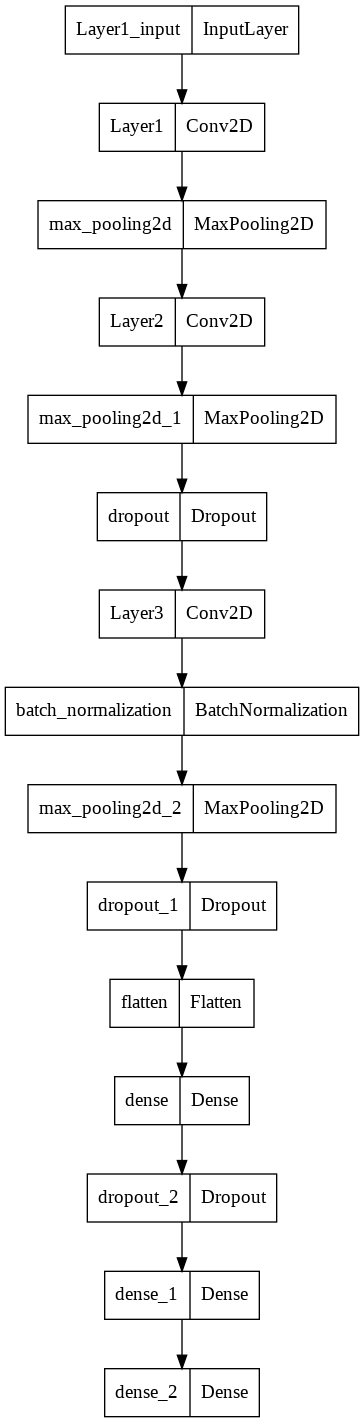

In [ ]:
plot_model(Aug_CNN)

In [ ]:
Aug_CNN.compile(
    optimizer = RMSprop(learning_rate=0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

In [ ]:
Aug_CNN_history = Aug_CNN.fit(
    train_generator,
    steps_per_epoch = STEP_SIZE_TRAIN,
    epochs=15, 
    validation_data=val_generator,
    validation_steps= STEP_SIZE_VALID
)

Epoch 1/15
560/560 [==============================] - 347s 619ms/step - loss: 1.8828 - accuracy: 0.3531 - val_loss: 1.5997 - val_accuracy: 0.5411
Epoch 2/15
560/560 [==============================] - 339s 606ms/step - loss: 0.9276 - accuracy: 0.6943 - val_loss: 0.7815 - val_accuracy: 0.7451
Epoch 3/15
560/560 [==============================] - 338s 603ms/step - loss: 0.5886 - accuracy: 0.8087 - val_loss: 0.6657 - val_accuracy: 0.8283
Epoch 4/15
560/560 [==============================] - 337s 601ms/step - loss: 0.4565 - accuracy: 0.8582 - val_loss: 0.8601 - val_accuracy: 0.8098
Epoch 5/15
560/560 [==============================] - 337s 601ms/step - loss: 0.3726 - accuracy: 0.8892 - val_loss: 0.4918 - val_accuracy: 0.8929
Epoch 6/15
560/560 [==============================] - 338s 603ms/step - loss: 0.3277 - accuracy: 0.9025 - val_loss: 0.8869 - val_accuracy: 0.7824
Epoch 7/15
560/560 [==============================] - 338s 604ms/step - loss: 0.2824 - accuracy: 0.9150 - val_loss: 0.7070 -

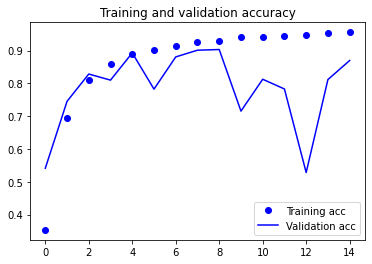

In [ ]:
acc = Aug_CNN_history.history['accuracy']
val_acc = Aug_CNN_history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()


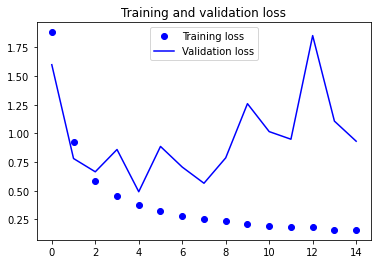

In [ ]:
loss = Aug_CNN_history.history['loss']
val_loss = Aug_CNN_history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

-----
###### B

In [ ]:
Aug_CNN = models.Sequential()
Aug_CNN.add(layers.Conv2D(128, (3, 3), activation='relu', name = 'Layer1', input_shape=(256,256,3,)))
Aug_CNN.add(layers.MaxPooling2D())
Aug_CNN.add(layers.Conv2D(64, (3, 3), activation='relu', name = 'Layer2'))
Aug_CNN.add(layers.MaxPooling2D())
Aug_CNN.add(layers.Dropout(0.5))
Aug_CNN.add(layers.Conv2D(128, (3, 3), activation='relu', name = 'Layer3'))
Aug_CNN.add(layers.BatchNormalization(axis = 3))
Aug_CNN.add(layers.MaxPooling2D())
Aug_CNN.add(layers.Dropout(0.5))


Aug_CNN.add(layers.Flatten())
Aug_CNN.add(layers.Dense(512, activation='relu'))
Aug_CNN.add(layers.Dropout(0.4))
Aug_CNN.add(layers.Dense(128, activation='relu'))
Aug_CNN.add(Dropout(0.25))
Aug_CNN.add(layers.Dense(10, activation='softmax'))

In [ ]:
Aug_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Conv2D)             (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 128)    0         
 )                                                               
                                                                 
 Layer2 (Conv2D)             (None, 125, 125, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0         
                                                                 
 Layer3 (Conv2D)             (None, 60, 60, 128)       7

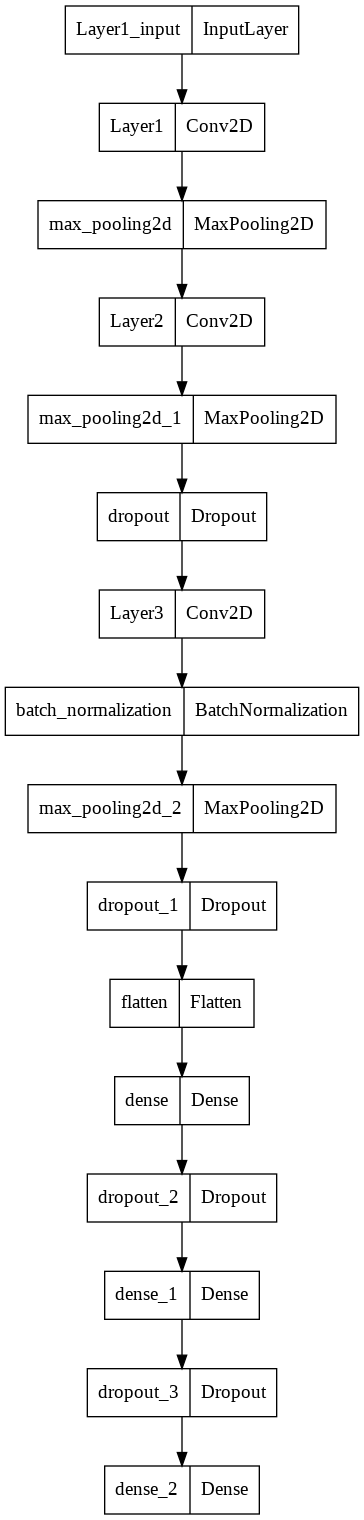

In [ ]:
plot_model(Aug_CNN)

In [ ]:
Aug_CNN.compile(
    optimizer = RMSprop(learning_rate=0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

In [ ]:
Aug_CNN_history = Aug_CNN.fit(
    train_generator,
    steps_per_epoch = STEP_SIZE_TRAIN,
    epochs=10, 
    validation_data=val_generator,
    validation_steps= STEP_SIZE_VALID
)

Epoch 1/10
560/560 [==============================] - 354s 624ms/step - loss: 1.7202 - accuracy: 0.4270 - val_loss: 1.4245 - val_accuracy: 0.6560
Epoch 2/10
560/560 [==============================] - 343s 611ms/step - loss: 0.8642 - accuracy: 0.7160 - val_loss: 0.8030 - val_accuracy: 0.7685
Epoch 3/10
560/560 [==============================] - 351s 626ms/step - loss: 0.5787 - accuracy: 0.8164 - val_loss: 0.8238 - val_accuracy: 0.8067
Epoch 4/10
560/560 [==============================] - 345s 617ms/step - loss: 0.4416 - accuracy: 0.8636 - val_loss: 0.7149 - val_accuracy: 0.8987
Epoch 5/10
560/560 [==============================] - 343s 612ms/step - loss: 0.3627 - accuracy: 0.8918 - val_loss: 0.8353 - val_accuracy: 0.8464
Epoch 6/10
560/560 [==============================] - 342s 610ms/step - loss: 0.3130 - accuracy: 0.9073 - val_loss: 1.0322 - val_accuracy: 0.7371
Epoch 7/10
560/560 [==============================] - 387s 690ms/step - loss: 0.2716 - accuracy: 0.9180 - val_loss: 0.9826 -

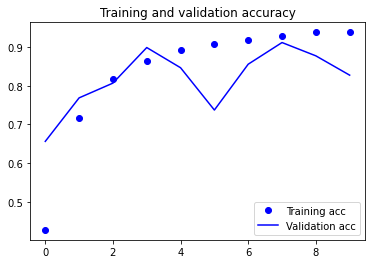

In [ ]:
acc = Aug_CNN_history.history['accuracy']
val_acc = Aug_CNN_history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()


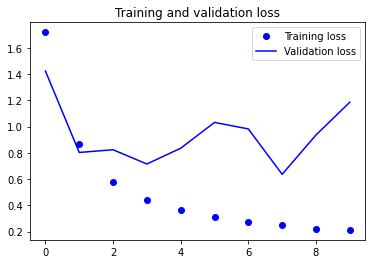

In [ ]:
loss = Aug_CNN_history.history['loss']
val_loss = Aug_CNN_history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### 4.Transfer Learning

In [ ]:
vgg19_model = VGG19(include_top = False, weights='imagenet', input_shape=(256,256,3))
vgg19_model.summary()
vgg19_model.trainable = False


80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [ ]:
Transfer_model = Sequential()
Transfer_model.add(vgg19_model)
Transfer_model.add(layers.Flatten())
Transfer_model.add(layers.Dense(512, activation='relu'))
Transfer_model.add(layers.Dense(256, activation='relu'))
Transfer_model.add(layers.Dense(10, activation='softmax'))
Transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               16777728  
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 36,936,010
Trainable params: 16,911,626
Non-trainable params: 20,024,384
_________________________________________________________________


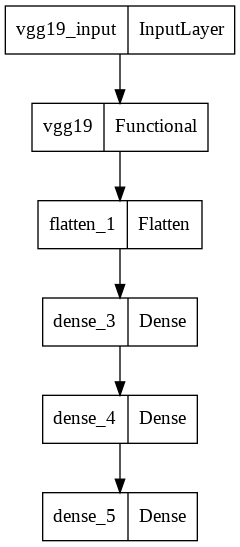

In [ ]:
plot_model(Transfer_model)

In [ ]:
Transfer_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

In [ ]:
Transfer_model_history = Transfer_model.fit(train_generator, steps_per_epoch=200, 
                    epochs=10, validation_data=val_generator, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 138s 664ms/step - loss: 1.9833 - acc: 0.3664 - val_loss: 1.6019 - val_acc: 0.5881
Epoch 2/10
200/200 [==============================] - 130s 650ms/step - loss: 1.3448 - acc: 0.7008 - val_loss: 1.0314 - val_acc: 0.7750
Epoch 3/10
200/200 [==============================] - 128s 642ms/step - loss: 0.9257 - acc: 0.8214 - val_loss: 0.7066 - val_acc: 0.8637
Epoch 4/10
200/200 [==============================] - 130s 647ms/step - loss: 0.6623 - acc: 0.8806 - val_loss: 0.4832 - val_acc: 0.9237
Epoch 5/10
200/200 [==============================] - 130s 651ms/step - loss: 0.4828 - acc: 0.9127 - val_loss: 0.3584 - val_acc: 0.9350
Epoch 6/10
200/200 [==============================] - 129s 644ms/step - loss: 0.3859 - acc: 0.9300 - val_loss: 0.2824 - val_acc: 0.9588
Epoch 7/10
200/200 [==============================] - 144s 721ms/step - loss: 0.3103 - acc: 0.9457 - val_loss: 0.2627 - val_acc: 0.9413
Epoch 8/10
200/200 [============================

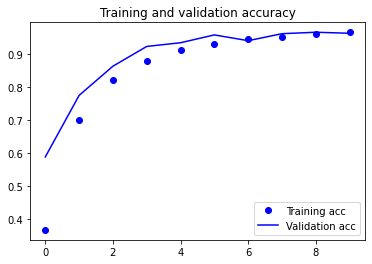

In [ ]:
acc = Transfer_model_history.history['acc']
val_acc = Transfer_model_history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()


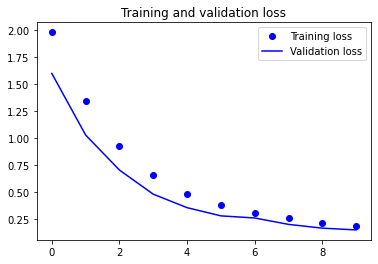

In [ ]:
loss = Transfer_model_history.history['loss']
val_loss = Transfer_model_history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### 5.Data Visualization

(1, 256, 256, 3)


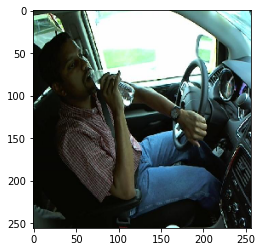

In [ ]:
img_tensor = next(train_generator)[0][0:1]
print(img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
convolutional_layers_count = 5
layer_outputs = [layer.output for layer in baseline_CNN.layers[:convolutional_layers_count]]
activation_model = models.Model(inputs=baseline_CNN.input, outputs=layer_outputs)
activation_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9_input (InputLayer)  [(None, 256, 256, 3)]    0         
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 128)       73856 

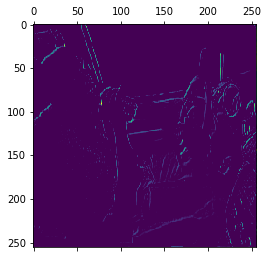

In [ ]:
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

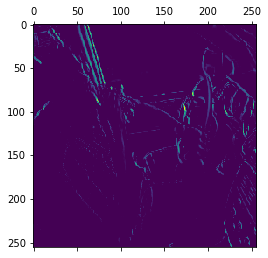

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


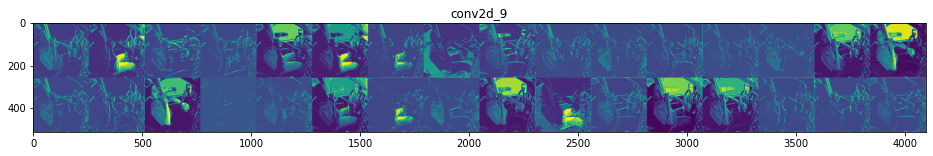

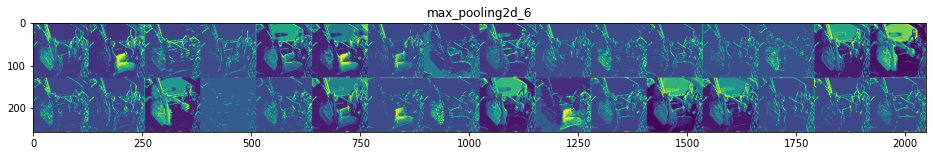

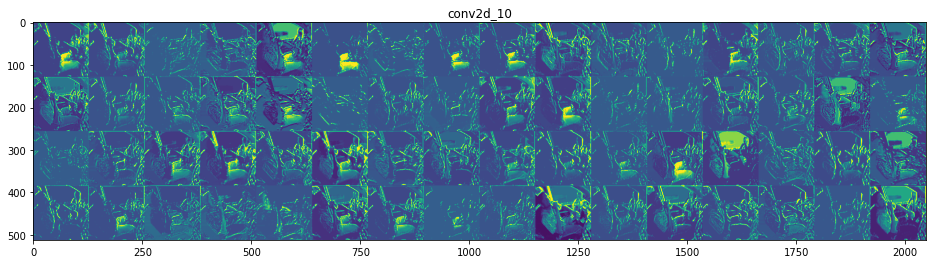

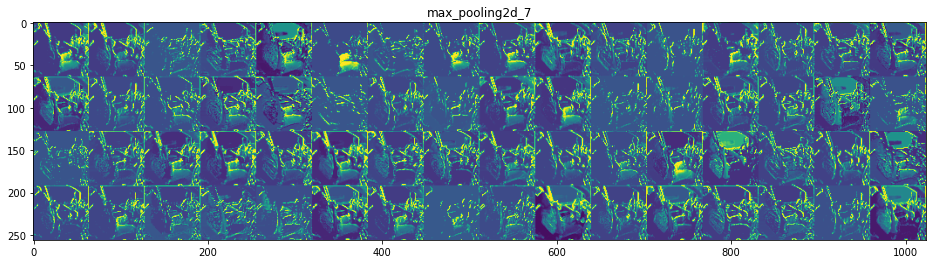

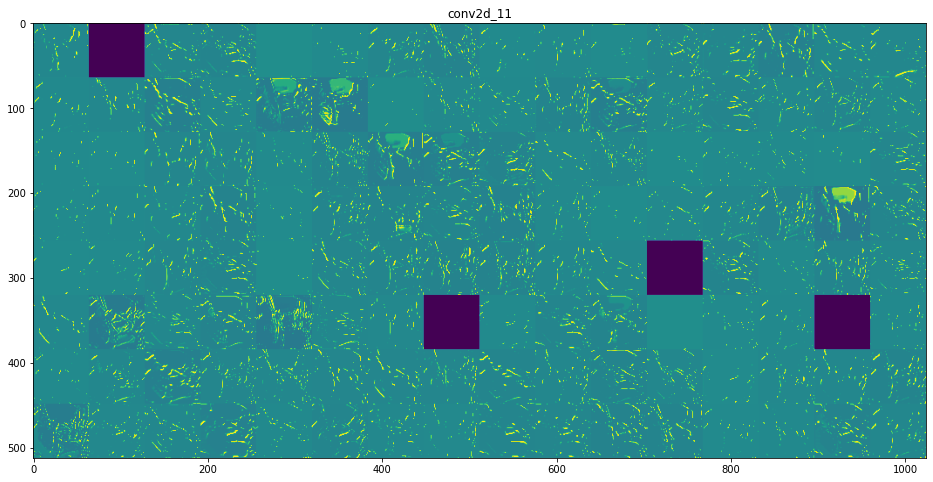

In [ ]:
layer_names = []
for layer in baseline_CNN.layers[:convolutional_layers_count]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()